In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
#hardware
device = 'cuda:0'

from circuit_pruner.utils import load_config

config = load_config('./configs/alexnet_sparse_config.py')
model = config.model.to('cpu')


### quick launch

To get a quick sense for the circuit diagramming tools interactivity, run the lines below. then you should be able to access the tool in your browser at 'http://localhost:8050/'


click a vertex or edge to isolate, click anywhere else in the graph to unisolate

In [31]:
import torch
circuit_dict = torch.load('extracted_circuits/alexnet_sparse/imagenet_2/actxgrad/312_circuit_diagram.pt')
circuit = circuit_dict['model']
dfs = [circuit_dict['edge_df'],circuit_dict['node_df']]

In [ ]:
from circuit_pruner.visualizer.circuit_gui import *

viz_folder = './visualization_cache/neurips_2022_diagram/'
port=8050
circuit_diagram = launch_circuit_gui(circuit,None,model,None,dfs=dfs,viz_folder=viz_folder,interactive=True,port=port,device=device)

### visualize your own circuit from scratch

In [39]:
#feature target

layer = 'features_6'
unit = 301

feature_targets = {layer:[unit]}

In [40]:
#dataloader

from circuit_pruner.data_loading import rank_image_data
from circuit_pruner.data_loading import single_image_data
from torchvision import transforms
from torch.utils import data


#make 'general' filter dataloader
imnet_kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}


#(this data loader is of 2 random images from each imagenet class)
imnet2_dataloader = data.DataLoader(rank_image_data(config.data_path,
                                            config.preprocess,
                                            label_file_path = config.label_file_path,
                                            class_folders=True),
                                            batch_size=5,
                                            shuffle=False,
                                            **imnet_kwargs)


In [41]:
#setup model

import torch
import os
from copy import deepcopy
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names
from circuit_pruner.dissected_Conv2d import dissect_model, set_across_model, set_model_target_node


#we need to 'dissect' the model, which allows us to access kernel-wise activation maps
kernel_rankable_model = dissect_model(deepcopy(model), dissect=True,store_ranks = True, device=device)
kernel_rankable_model.to(device)


set_model_target_node(kernel_rankable_model,layer,unit)
set_across_model(kernel_rankable_model,'rank_field','image')
set_across_model(kernel_rankable_model,'absolute_rank',True)

AlexNet(
  (features): Sequential(
    (0): dissected_Conv2d(
      (preadd_conv): Conv2d(3, 192, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), groups=3, bias=False)
    )
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): dissected_Conv2d(
      (preadd_conv): Conv2d(64, 12288, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64, bias=False)
    )
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): dissected_Conv2d(
      (preadd_conv): Conv2d(192, 73728, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
    )
    (7): ReLU()
    (8): dissected_Conv2d(
      (preadd_conv): Conv2d(384, 98304, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
    )
    (9): ReLU()
    (10): dissected_Conv2d(
      (preadd_conv): Conv2d(256, 65536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256, bias=False)
    

In [42]:
#actually extract ranks by running images through model

from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model



clear_ranks_across_model(kernel_rankable_model)

iter_dataloader = iter(imnet2_dataloader)
iters = len(iter_dataloader)

for it in range(iters):

    inputs, label = next(iter_dataloader)
    inputs = inputs.to(device)
    

    kernel_rankable_model.zero_grad()

    try:
        outputs = kernel_rankable_model(inputs)
    except:
        pass

ranks = get_ranklist_from_dissected_Conv2d_modules(kernel_rankable_model, structure='kernels')

In [43]:
#extract model (large circuit)

from circuit_pruner.extraction import model_ranks_2_circuit_model


sparsity = .9

kernel_pruned_circuit,kernel_mask = model_ranks_2_circuit_model(ranks,sparsity,
                                                           model,feature_targets,device,
                                                           structure='kernels',use_effective_mask=True,
                                                           rank_field='image')


features_6 effective last layer
target sparsity: 0.9
total params to feature: 12672

kept params in original mask: 11405      (total params * sparsity)
original mask: 300460 params
effective mask: 300460 params
effective_sparsity: 0.8999368686868687


------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:13<00:00, 37.06it/s]



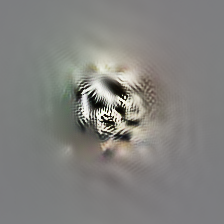

(13, 13)
(6, 6)
[(62.0, 161.0), (62.0, 161.0)]


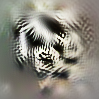

In [44]:
#visualize large circuit (original feature)

from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field

featviz_in_recep_field(kernel_pruned_circuit,layer,0,margin=0)

In [51]:
#extract model (small circuit)

from circuit_pruner.extraction import model_ranks_2_circuit_model


sparsity = .02

kernel_pruned_circuit,kernel_mask = model_ranks_2_circuit_model(ranks,sparsity,
                                                           model,feature_targets,device,
                                                           structure='kernels',use_effective_mask=True,
                                                           rank_field='image')


features_6 effective last layer
target sparsity: 0.02
total params to feature: 12672

kept params in original mask: 254      (total params * sparsity)
original mask: 10597 params
effective mask: 9720 params
effective_sparsity: 0.015782828282828284


In [52]:
kernel_pruned_circuit

Sequential(
  (features_0): Conv2d(3, 25, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (features_1): ReLU(inplace=True)
  (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_3): Conv2d(25, 17, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (features_4): ReLU(inplace=True)
  (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_6): Conv2d(17, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 


100%|██████████| 512/512 [00:07<00:00, 72.67it/s]



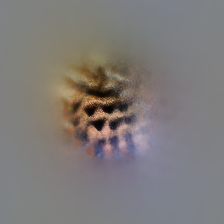

(13, 13)
(6, 6)
[(62.0, 161.0), (62.0, 161.0)]


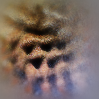

In [53]:
featviz_in_recep_field(kernel_pruned_circuit,layer,0,margin=0)

In [ ]:
#launch gui
from circuit_pruner.visualizer.circuit_gui import *
port=8050

circuit_diagram = launch_circuit_gui(kernel_pruned_circuit,kernel_mask,
                                     model,ranks,interactive=True,
                                     port=port,device=device)